In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as opt
from datasets import load_metric
from torch.utils.data import DataLoader, random_split
from tqdm.notebook import tqdm
import torchinfo

from utils import OCRTokenizer, OCRDataset, collate_batch, save_experiment_info

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

## Tokenizer & Dataset

In [3]:
tokenizer = OCRTokenizer('./synthetic_dataset/train/labels.txt')
tokenizer.counter.most_common(5)

[(' ', 10061), ('8', 3028), ('S', 3012), ('b', 3006), ('V', 2992)]

In [4]:
train_dataset = OCRDataset('./synthetic_dataset/train/', tokenizer, do_train_transform=True, image_size=(64, 256))  # need quadratic images for vit, 64 h for others
val_dataset = OCRDataset('./synthetic_dataset/val/', tokenizer, do_train_transform=False, image_size=(64, 256))
test_dataset = OCRDataset('./synthetic_dataset/test/', tokenizer, do_train_transform=False, image_size=(64, 256))
len(train_dataset), len(val_dataset), len(test_dataset)

(20000, 1500, 5000)

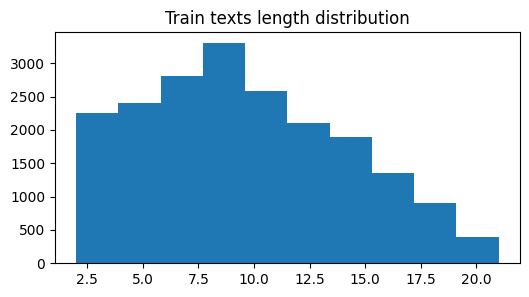

In [5]:
plt.figure(figsize=(6, 3))
plt.hist(np.array(list(map(lambda x: len(x[1]), train_dataset.data))))
plt.title('Train texts length distribution')
plt.show()

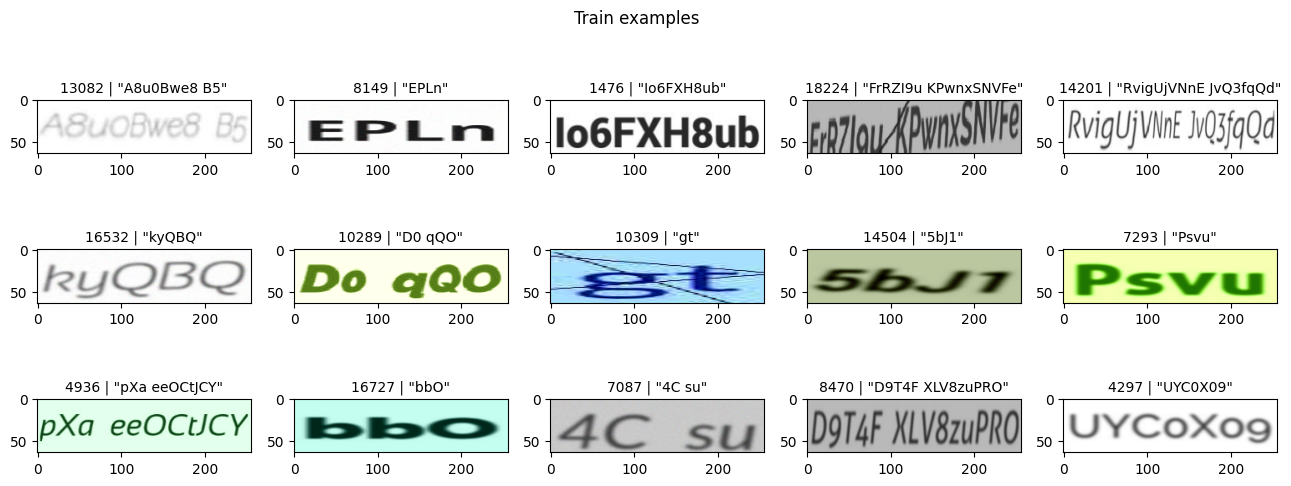

In [6]:
fig, axs = plt.subplots(3, 5, figsize=(16, 5.5))
for i in range(15):
    ax = axs[i // 5][i % 5]
    random_index = np.random.randint(0, len(train_dataset))
    ax.imshow(train_dataset.__getitem__(random_index)['image'].permute(1, 2, 0))
    ax.grid(False)
    text = "".join(tokenizer.decode(train_dataset[random_index]["labels"]))
    ax.set_title(f'{random_index} | "{text}"', fontsize=10)
fig.suptitle('Train examples')
plt.show()

## Modeling

In [8]:
from transformers import ViTConfig
from modeling.encoders.cnn_bilstm import OCR_CRNN, OCR_CARNN, OCR_CRNNA
from modeling.encoders.cnn_transformer import OCR_CNNBERT
from modeling.encoders.vit_bilstm import OCR_ViTRNN

2023-04-04 05:44:08.532883: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-04 05:44:08.563071: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 05:44:09.102563: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [9]:
# model = OCR_CNNBERT(vocab_size=len(tokenizer), hidden_dim=128,
#                     nhead=2, dim_feedforward=512, tr_layers=4, dropout=0.1).to(device).eval()
# model

In [25]:
model = OCR_CRNN(vocab_size=len(tokenizer), hidden_dim=128,
                 lstm_layers=1, dropout=0.1).to(device).eval()
model

/home/hivaze/miniconda3/envs/torch/lib/python3.9/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


OCR_CRNN(
  (encoder): CNNImageEncoderV2(
    (layers): Sequential(
      (0): ConvBlock(
        (bn): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4), bias=False)
        (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (activation): Hardswish()
      )
      (1): ConvBlock(
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
        (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (activation): Hardswish()
      )
      (2): ConvBlock(
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
        (pooling): MaxPool2d(ke

In [26]:
# config = ViTConfig(hidden_size=128, num_hidden_layers=5,
#                    intermediate_size=256, patch_size=24, image_size=256,
#                    attention_probs_dropout_prob=0.1, hidden_dropout_prob=0.1, num_attention_heads=2)
# model = OCR_ViTRNN(vit_config=config, vocab_size=len(tokenizer), lstm_layers=2, dropout=0.1).to(device).eval()
# model

In [27]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
OCR_CRNN                                 --
├─CNNImageEncoderV2: 1-1                 --
│    └─Sequential: 2-1                   --
│    │    └─ConvBlock: 3-1               7,782
│    │    └─ConvBlock: 3-2               100,416
│    │    └─ConvBlock: 3-3               204,928
│    │    └─ConvBlock: 3-4               147,712
│    │    └─ConvBlock: 3-5               147,712
│    │    └─ConvBlock: 3-6               147,712
│    └─Dropout: 2-2                      --
│    └─Sequential: 2-3                   --
│    │    └─LayerNorm: 3-7               256
│    │    └─Linear: 3-8                  16,512
├─BiLSTMImageDecoder: 1-2                --
│    └─LayerNorm: 2-4                    256
│    └─LSTM: 2-5                         264,192
│    └─Linear: 2-6                       16,705
├─LogSoftmax: 1-3                        --
Total params: 1,054,183
Trainable params: 1,054,183
Non-trainable params: 0

In [28]:
model.encoder(torch.rand([2, 3, 64, 256]).to(device)).shape

torch.Size([2, 64, 128])

## Training

In [29]:
train_loader = DataLoader(train_dataset, batch_size=96, shuffle=True, collate_fn=lambda x: collate_batch(x, tokenizer), num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, collate_fn=lambda x: collate_batch(x, tokenizer), num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, collate_fn=lambda x: collate_batch(x, tokenizer), num_workers=4)

In [30]:
num_epochs = 80
criterion = nn.CTCLoss(zero_infinity=True, blank=tokenizer.pad_token_id)
# criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = opt.AdamW(model.parameters(), lr=5e-4)
wer_metric, cer_metric = load_metric('wer'), load_metric('cer')

In [31]:
def evaluate(model, data_loader):
    model.eval()
    losses, wer_scores, cer_scores = [], [], []
    for batch in data_loader:
        with torch.inference_mode():
            inputs, target_labels, target_lengths = batch['inputs'].to(device), batch['labels'].to(device), batch['lengths'].to(device)
            bs = inputs.shape[0]

            predictions = model(inputs)
            pridicted_labels = predictions.permute(1, 0, 2).argmax(-1)

            # CTCLoss
            input_lengths = torch.full(size=(bs,), fill_value=predictions.shape[0], dtype=torch.long)
            loss = criterion(predictions, target_labels, input_lengths, target_lengths)

            # CrossEntropy (needs same seq len in targets and predictions)
            # loss = criterion(predictions.permute(1, 0, 2).contiguous().view(-1, predictions.shape[-1]), target_labels.view(-1))

            # WER & CER
            predicted_texts = tokenizer.decode_batch(pridicted_labels, drop_special=True, to_text=True)
            target_texts = tokenizer.decode_batch(target_labels, drop_special=True, to_text=True)

            wer_score = wer_metric.compute(predictions=predicted_texts, references=target_texts)
            cer_score = cer_metric.compute(predictions=predicted_texts, references=target_texts)

        losses.append(loss.detach().item())
        wer_scores.append(wer_score)
        cer_scores.append(cer_score)

    return np.mean(losses).round(5), np.mean(wer_scores).round(5), np.mean(cer_scores).round(5)

In [32]:
%%time
evaluate(model, val_loader)

CPU times: user 2.28 s, sys: 168 ms, total: 2.45 s
Wall time: 2.64 s


(34.60657, 1.0, 6.69461)

In [33]:
%%time
evaluate(model, test_loader)

CPU times: user 5.95 s, sys: 260 ms, total: 6.21 s
Wall time: 6.41 s


(34.24578, 1.0, 6.68966)

In [34]:
def train(model, checkpoints_dir):
    Path(checkpoints_dir).mkdir(parents=True, exist_ok=True)
    losses_history = {
        'train': [],
        'eval': []
    }
    min_eval_loss = 999999999.9

    for epoch in tqdm(range(num_epochs)):
        model.train()
        print(f'---------- | Epoch: {epoch} | ----------')
        train_losses = []

        for batch in train_loader:
            inputs, target_labels, target_lengths = batch['inputs'].to(device), batch['labels'].to(device), batch['lengths'].to(device)

            predictions = model(inputs)
            input_lengths = torch.full(size=(inputs.shape[0],), fill_value=predictions.shape[0], dtype=torch.long)
            loss = criterion(predictions, target_labels, input_lengths, target_lengths)

            loss.backward()

            train_losses.append(loss.item())

            optimizer.step()
            optimizer.zero_grad()

            # progress_bar.update(1)
        train_loss = np.array(train_losses).mean()
        eval_scores = evaluate(model, val_loader)

        losses_history['train'].append(train_loss)
        losses_history['eval'].append(eval_scores[0])

        print(f'[TRAIN] Mean epoch loss: {train_loss}')
        print(f'[EVAL] Mean epoch loss: {eval_scores[0]}, WER: {eval_scores[1]}, CER: {eval_scores[2]}')

        if eval_scores[0] < min_eval_loss:
            print(f'Current best on eval, saving model to {checkpoints_dir}...')
            torch.save(model, checkpoints_dir + 'best_model.pth')
            tokenizer.save_to(checkpoints_dir + 'tokenizer.pickle')
            min_eval_loss = eval_scores[0]

        save_experiment_info(model, losses_history, checkpoints_dir + 'experiment_info.json')

    return losses_history

In [35]:
history = train(model, checkpoints_dir='./experiments/cnn_v2_128_64seq_lstm_4h_1l_80e/')

  0%|          | 0/80 [00:00<?, ?it/s]

---------- | Epoch: 0 | ----------
[TRAIN] Mean epoch loss: 5.685479646671318
[EVAL] Mean epoch loss: 4.41248, WER: 1.0, CER: 0.99987
Current best on eval, saving model to ./experiments/cnn_v2_128_64seq_lstm_4h_1l_80e/...
---------- | Epoch: 1 | ----------
[TRAIN] Mean epoch loss: 4.4007654561254075
[EVAL] Mean epoch loss: 4.39413, WER: 1.0, CER: 1.0
Current best on eval, saving model to ./experiments/cnn_v2_128_64seq_lstm_4h_1l_80e/...
---------- | Epoch: 2 | ----------
[TRAIN] Mean epoch loss: 4.363267764359891
[EVAL] Mean epoch loss: 4.2996, WER: 1.0, CER: 1.0
Current best on eval, saving model to ./experiments/cnn_v2_128_64seq_lstm_4h_1l_80e/...
---------- | Epoch: 3 | ----------
[TRAIN] Mean epoch loss: 4.0696600996805525
[EVAL] Mean epoch loss: 3.65676, WER: 1.0, CER: 0.99196
Current best on eval, saving model to ./experiments/cnn_v2_128_64seq_lstm_4h_1l_80e/...
---------- | Epoch: 4 | ----------
[TRAIN] Mean epoch loss: 2.3982148291821965
[EVAL] Mean epoch loss: 1.42827, WER: 0.


KeyboardInterrupt



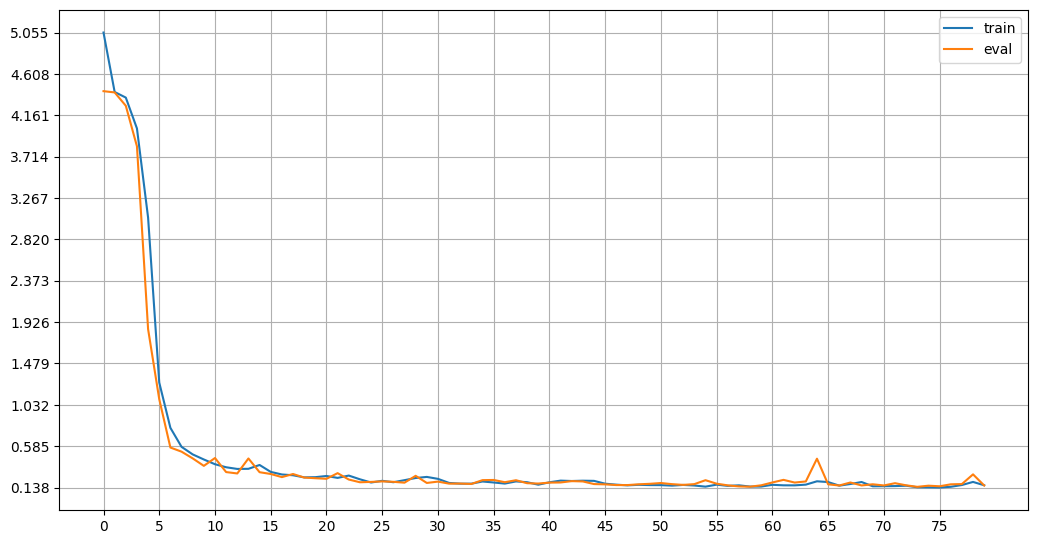

In [21]:
fig = plt.gcf()
fig.set_size_inches(12.5, 6.5)
plt.plot(history['train'], label = 'train')
plt.plot(history['eval'], label = 'eval')
plt.yticks(np.linspace(min(history['train']), max(history['train']), 12))
plt.xticks(range(0, len(history['train']), 5))
plt.grid()
plt.legend()
plt.show()

In [22]:
evaluate(model, val_loader), evaluate(model, test_loader)

((0.16036, 0.3334, 0.08411), (0.1364, 0.33068, 0.07789))

## Manual testing

In [27]:
best_model = torch.load('./experiments/cnn_v2_128_64seq_lstm_2l_80e/best_model.pth').eval()

In [28]:
evaluate(best_model, val_loader)

(0.1129, 0.26284, 0.06149)

In [29]:
evaluate(best_model, test_loader)

(0.10785, 0.24169, 0.05619)

In [26]:
cer_metric.compute(predictions=['Hello 34'], references=['Hell dear'])

0.5555555555555556

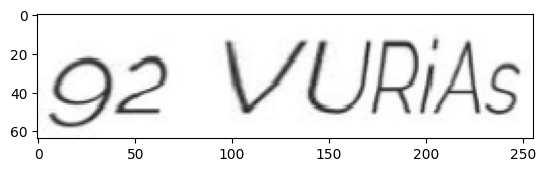

In [58]:
test_image = test_dataset[155]['image']
plt.imshow(test_image.permute(1, 2, 0))

In [59]:
tokenizer.decode(best_model(test_image.unsqueeze(0).to(device)).permute(1, 0, 2).argmax(-1), drop_special=True)

['9', '2', '2', ' ', ' ', 'V', 'U', 'R', 'i', 'A', 's']